In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams.update({
    'image.origin' : 'lower',
    'image.interpolation' : 'nearest',
    'figure.dpi' : 100,
})
from matplotlib.colors import LogNorm, SymLogNorm, Normalize

import numpy as np
from magpyx.fdpr2 import console, tools
from magpyx.instrument import set_camera_roi

from purepyindi import INDIClient
from purepyindi import SwitchState as SwitchState0

from astropy.io import fits
from poppy import zernike
import cupy as cp

from scipy.ndimage import binary_closing, binary_erosion

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
import scoobi.imshows as imshows
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.utils as utils

import lina


INFO:numexpr.utils:NumExpr defaulting to 12 threads.
/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


# with existing data

In [3]:
config_params = tools.Configuration('fdpr2_fpm')

(3, 256, 256)


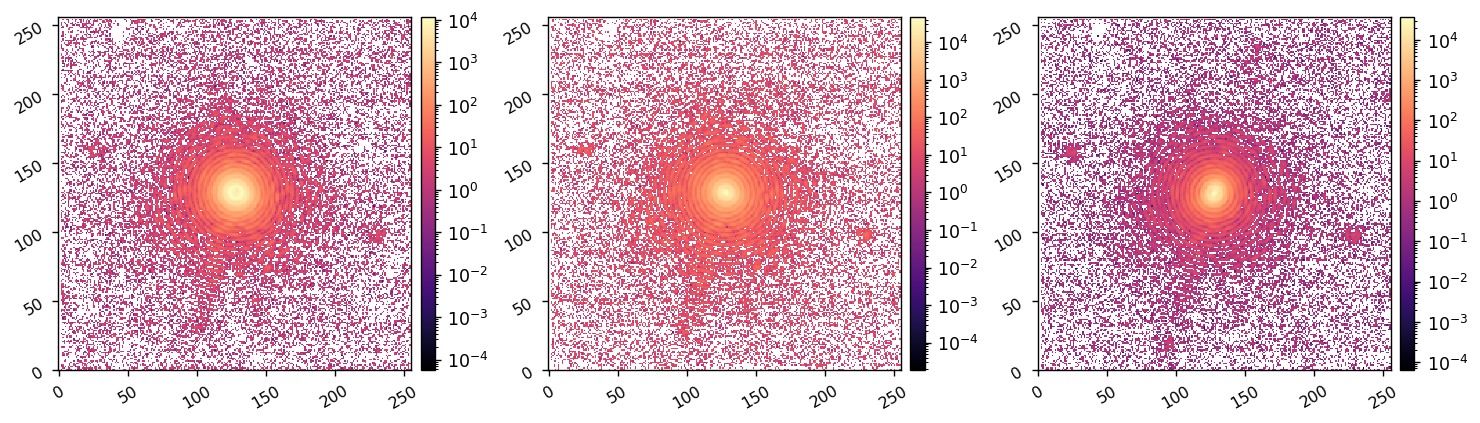

In [3]:
# read in some data
# with fits.open('/opt/MagAOX/calib/fdpr2/kilo_dmdiv/measrespM/measrespM__20241003-151832.fits') as f:
#     Imeas = f[0].data[0] # data from old response matrix

# read in some data
# with fits.open('/opt/MagAOX/calib/fdpr2/kilo_dmdiv/measrespM/measrespM__20250103-102551.fits') as f:
#     Imeas = f[0].data[0] # data from old response matrix

# with fits.open('/opt/MagAOX/calib/fdpr2/kilo_dmdiv/measrespM/measrespM__20250107-144144.fits') as f:
#     Imeas = f[0].data[0] # data from old response matrix

with fits.open('/opt/MagAOX/calib/fdpr2/kilo_dmdiv/measrespM/measrespM__20250110-104250.fits') as f:
    Imeas = f[0].data[0] # data from old response matrix

print(Imeas.shape)
imshows.imshow3(Imeas[0], Imeas[1], Imeas[2], lognorm=1)

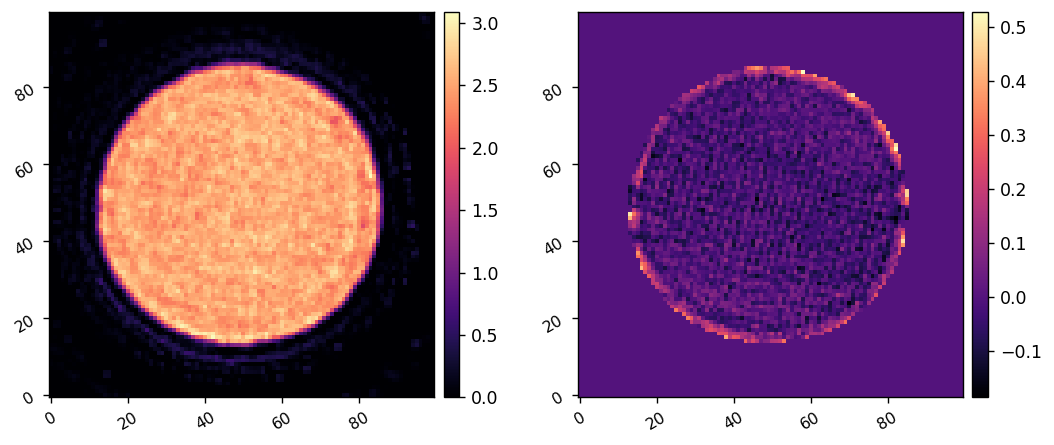

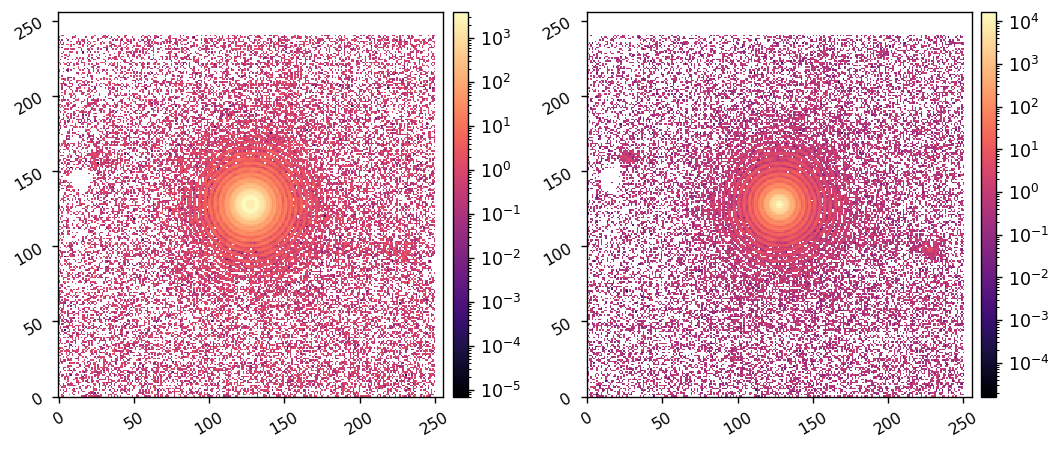

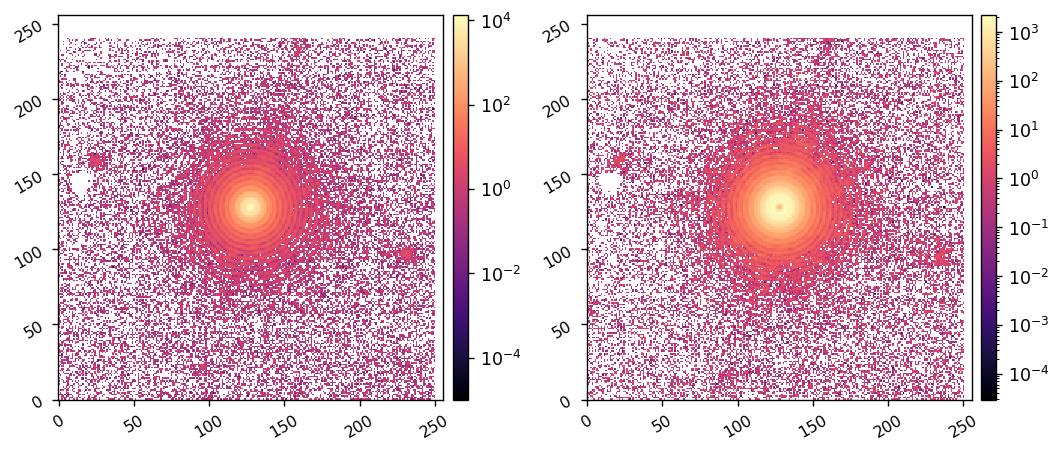

In [3]:
fname = 'data/20250121_fdpr2_prefpm_ring_16.pkl'

fdpr2_data = utils.load_pickle(fname)
Imeas = fdpr2_data['Imeas']
imshow2(fdpr2_data['AMP'], fdpr2_data['PHS'], npix=100)
imshow2(Imeas[0], Imeas[1], lognorm=1)
imshow2(Imeas[2], Imeas[3], lognorm=1)

In [5]:
fdpr2_data.keys()

dict_keys(['phase_est', 'amp_est', 'obj_val', 'fit_params', 'fitdict', 'AMP', 'PHS', 'dm_command', 'Imeas'])

In [8]:
fdpr2_data['fit_params']

array([0.        , 0.        , 0.        , ..., 0.02753479, 0.01702255,
       0.00938931])

2.1 1e-08 0.0 175.0


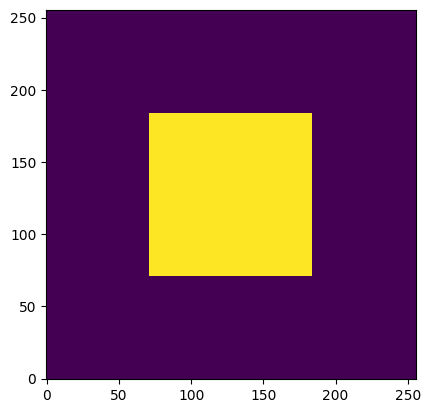

In [4]:
# parse configuration
config_params = tools.Configuration('fdpr2_fpm')

probevals = np.asarray(config_params.get_param('diversity', 'probevals', float))
wavelen = config_params.get_param('estimation', 'wavelen', float)
scalefactor = config_params.get_param('estimation', 'scalefactor', float)
N = config_params.get_param('estimation', 'N', int)
nside = config_params.get_param('estimation', 'Nfit', int)
tol = config_params.get_param('estimation', 'tol0', float)
reg = config_params.get_param('estimation', 'reg', float)
wreg = config_params.get_param('estimation', 'wreg', float)
print(scalefactor, tol, reg, wreg)

fitmask, fitslice = tools.get_fitting_region( (N,N), nside)
plt.imshow(fitmask)
Eprobes = tools.get_defocus_probes(fitmask, probevals, wavelen, scalefactor=scalefactor)

In [28]:
tools.run_phase_retrieval

<function magpyx.fdpr2.estimation.run_phase_retrieval(Imeas, fitmask, tol, reg, wreg, Eprobes, init_params=None, bounds=True, modes=None, fit_amp=True)>

In [5]:
# run the estimation
estdict = tools.run_phase_retrieval(Imeas, fitmask, tol, reg, wreg, Eprobes)

In [8]:
tol

1e-08

In [6]:
# amplitude mask and zernikes
amp = estdict['amp_est']
amp_thresh = tools.threshold_otsu(estdict['amp_est'])
mask = estdict['amp_est'] > amp_thresh

zmodes = zernike.arbitrary_basis(cp.array(mask), nterms=3, outside=0).get()

In [7]:
coeffs = np.sum(zmodes*estdict['phase_est'], axis=(-2,-1)) / zmodes[0].sum()
phase_ttrem = estdict['phase_est'] - np.sum(coeffs[:,None,None] * zmodes, axis=0)

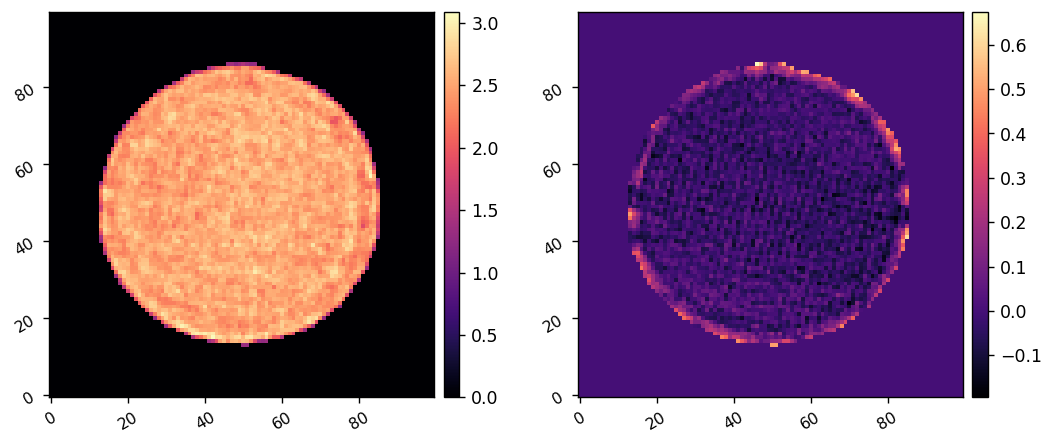

In [8]:
imshows.imshow2(amp*mask, phase_ttrem*mask, npix=100)

# pad measured PSFs for higher resolution in retrieved phase

In [9]:
pad_factor = 3
N = Imeas.shape[1]*pad_factor
side_pad = (N-Imeas.shape[1])//2
print(N, side_pad)

Imeas_2 = np.pad(
    Imeas, 
    ((0,0), (side_pad, side_pad), (side_pad, side_pad))
)
Imeas_2.shape

768 256


(4, 768, 768)

In [57]:
nside*pad_factor

226

In [10]:
fitmask, fitslice = tools.get_fitting_region((N, N), 3*113)
Eprobes = tools.get_defocus_probes(fitmask, probevals, wavelen, scalefactor=scalefactor)

In [11]:
# let's try passing in upscaled version of previous estimate as starting point
from scipy.ndimage import zoom

amp_input = zoom(estdict['amp_est'], pad_factor)
phase_input = zoom(phase_ttrem, pad_factor)

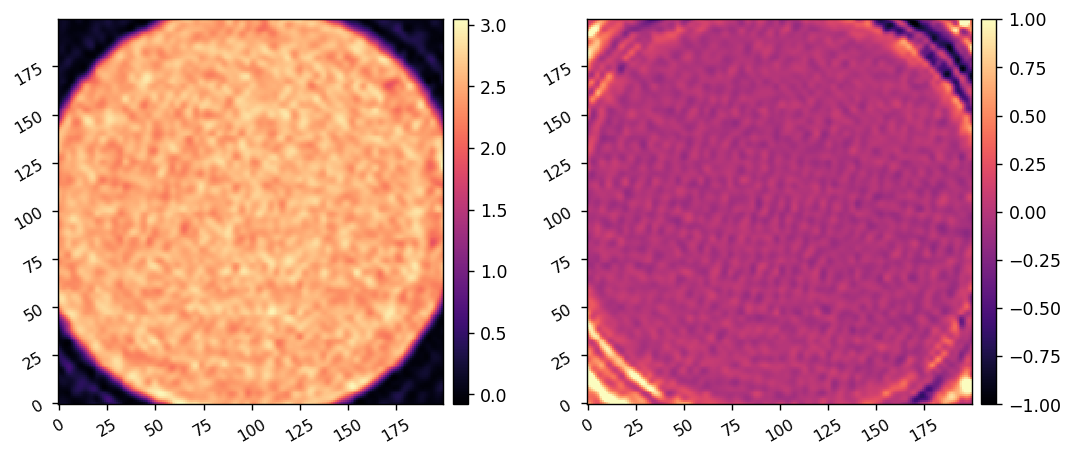

In [12]:
imshows.imshow2(amp_input, phase_input, npix=200, vmin2=-1, vmax2=1)


In [13]:
init_params = np.concatenate([amp_input[fitmask], phase_input[fitmask]], axis=0)
estdict_2 = tools.run_phase_retrieval(Imeas_2, fitmask, tol, reg, wreg, Eprobes, init_params=init_params)

In [14]:
amp_2 = estdict_2['amp_est']
amp_thresh = tools.threshold_otsu(estdict['amp_est'])
mask = estdict_2['amp_est'] > amp_thresh
mask = binary_erosion(mask, iterations=1) # clean up stray pixels

zmodes = zernike.arbitrary_basis(cp.array(mask), nterms=3, outside=0).get()

In [15]:
coeffs = np.sum(zmodes*estdict_2['phase_est'], axis=(-2,-1)) / zmodes[0].sum()
phase_ttrem_2 = estdict_2['phase_est'] - np.sum(coeffs[:,None,None] * zmodes, axis=0)

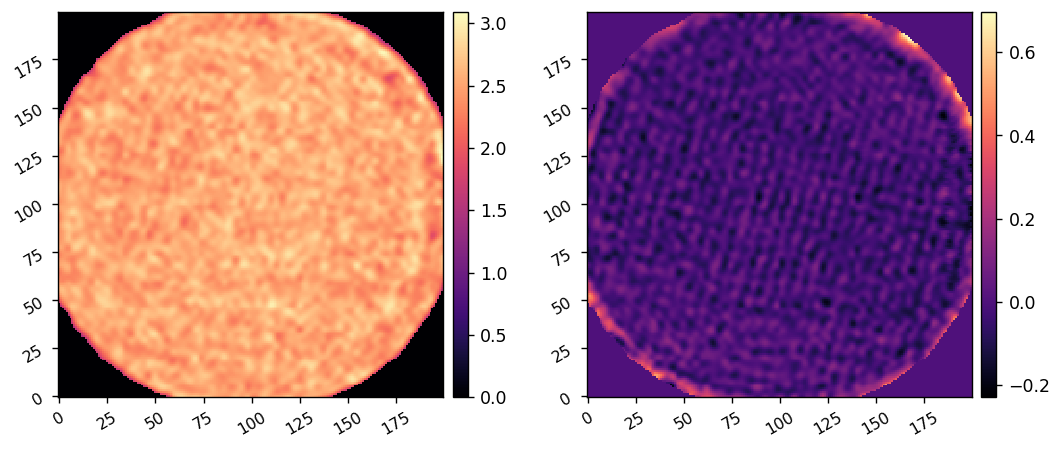

In [16]:
imshows.imshow2(amp_2*mask, phase_ttrem_2 * mask, npix=200)

# Now do it again.

In [45]:
pad_factor = 2
N = Imeas_2.shape[1]*pad_factor
side_pad = (N-Imeas_2.shape[1])//2
print(N, side_pad)

Imeas_3 = np.pad(
    Imeas_2, 
    ((0,0), (side_pad, side_pad), (side_pad, side_pad))
)
Imeas_3.shape

1024 256


(4, 1024, 1024)

In [46]:
fitmask, fitslice = tools.get_fitting_region((N, N), 4*113)
Eprobes = tools.get_defocus_probes(fitmask, probevals, wavelen, scalefactor=scalefactor)

In [47]:
# let's try passing in upscaled version of previous estimate as starting point
from scipy.ndimage import zoom

amp_input = zoom(estdict_2['amp_est'], pad_factor)
phase_input = zoom(phase_ttrem_2, pad_factor)

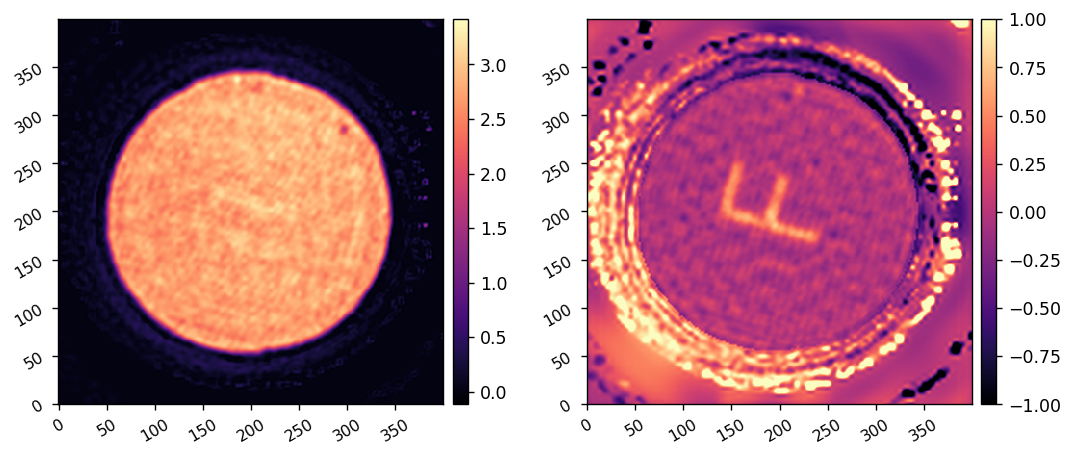

In [48]:
imshows.imshow2(amp_input, phase_input, npix=400, vmin2=-1, vmax2=1)


In [89]:
init_params = np.concatenate([amp_input[fitmask], phase_input[fitmask]], axis=0)
estdict_3 = tools.run_phase_retrieval(Imeas_3, fitmask, tol, reg, wreg, Eprobes, init_params=init_params)

In [90]:
amp_3 = estdict_3['amp_est']
amp_thresh = tools.threshold_otsu(estdict['amp_est'])
mask = estdict_3['amp_est'] > amp_thresh
mask = binary_erosion(mask, iterations=1) # clean up stray pixels

zmodes = zernike.arbitrary_basis(cp.array(mask), nterms=3, outside=0).get()

In [91]:
coeffs = np.sum(zmodes*estdict_3['phase_est'], axis=(-2,-1)) / zmodes[0].sum()
phase_ttrem_3 = estdict_3['phase_est'] - np.sum(coeffs[:,None,None] * zmodes, axis=0)

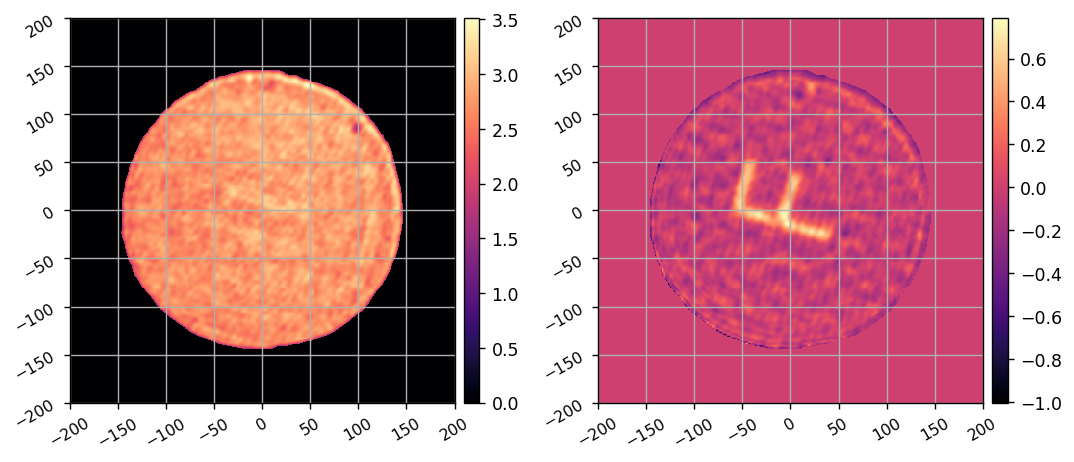

In [92]:
imshows.imshow2(amp_3*mask, phase_ttrem_3 * mask, npix=400, pxscl=1, grid=True)

# Now fit a better circular mask and do the rotation and interpolation required to get the PR estimate ready for the model.

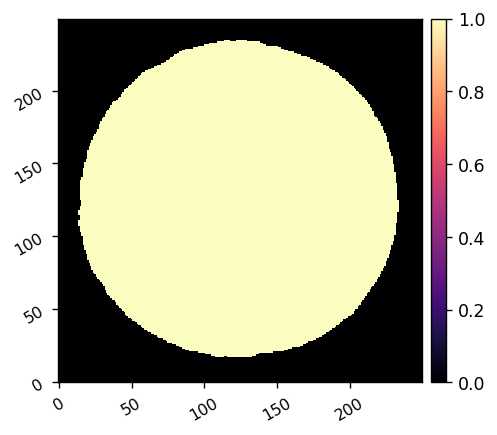

In [17]:
imshow1(mask, npix=250)

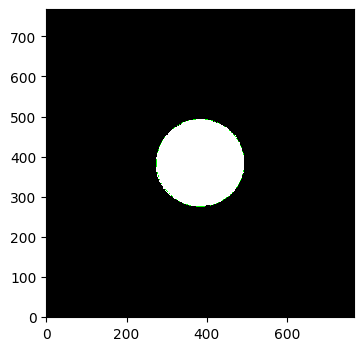

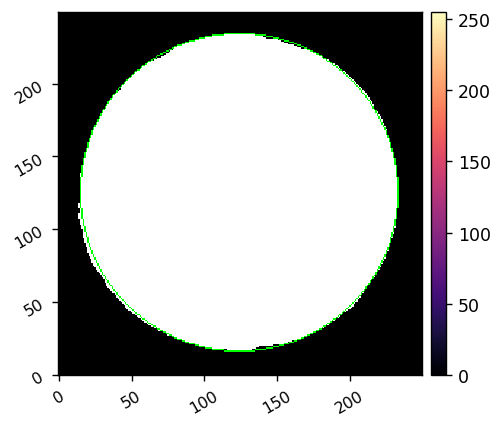

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

# Load picture and detect edges
# image = img_as_ubyte(data.coins()[160:230, 70:270])
image = img_as_ubyte(mask)
# image = img_as_ubyte(np.abs(fitdict['phase_est'])/np.max(np.abs(fitdict['phase_est'])))
edges = canny(image, sigma=1, low_threshold=10, high_threshold=50)

# Detect two radii
hough_radii = np.arange(100, 150, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (0, 255, 0)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

imshow1(image, npix=250)

218


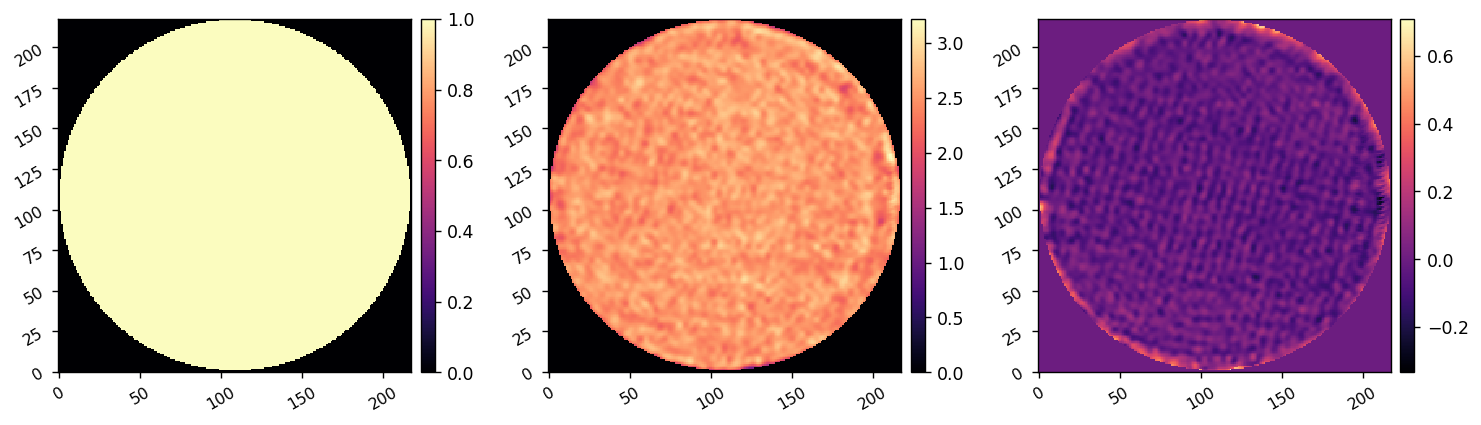

In [19]:
amp_upsampled = amp_2[center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
phs_upsampled = phase_ttrem_2[center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]

# amp_upsampled = amp_3[center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]
# phs_upsampled = phase_ttrem_3[center_y-radii[0]:center_y+radii[0], center_x-radii[0]:center_x+radii[0]]

npix_pr = amp_upsampled.shape[0]
print(npix_pr)
y,x = (np.indices((npix_pr, npix_pr)) - npix_pr/2+1/2)
r = np.sqrt(x**2 + y**2)
fit_mask = r<(radii[0]-1)

# amp_upsampled *= fit_mask
# phs_upsampled *= fit_mask
imshow3(fit_mask, amp_upsampled*fit_mask, phs_upsampled*fit_mask)

(1000, 1000)


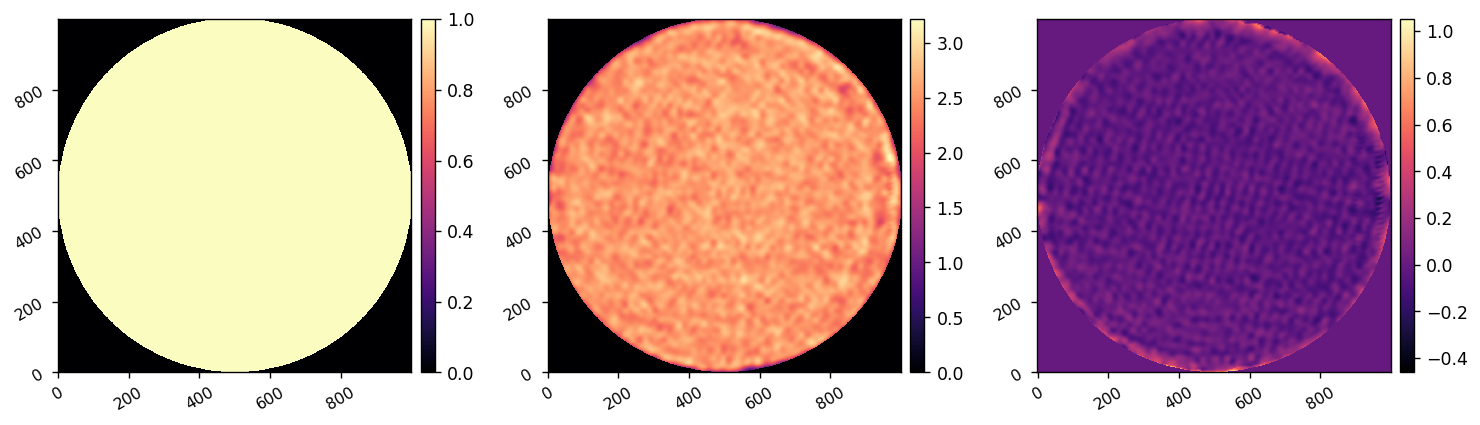

In [20]:
npix = 1000
y,x = (xp.indices((npix, npix)) - npix/2+1/2)
r = xp.sqrt(x**2 + y**2)
pup_mask = r<(npix/2)

amp_interpped = lina.utils.interp_arr(xp.array(amp_upsampled), 1/npix_pr, 1/npix, order=1) * pup_mask
phs_interpped = lina.utils.interp_arr(xp.array(phs_upsampled), 1/npix_pr, 1/npix, order=1) * pup_mask
print(amp_interpped.shape)

imshow3(pup_mask, amp_interpped, phs_interpped)

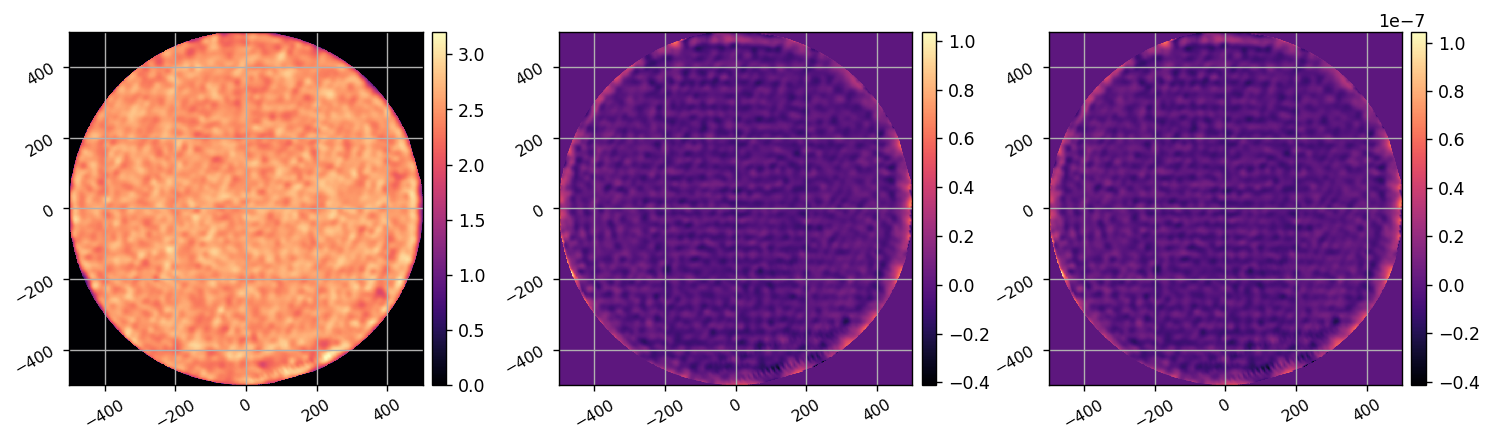

In [21]:
rotation = 74
amp_rotated = _scipy.ndimage.rotate(xp.array(amp_interpped), rotation, reshape=False, order=1)
phs_rotated = _scipy.ndimage.rotate(xp.array(phs_interpped), rotation, reshape=False, order=1)
opd = phs_rotated * wavelen/ (2*np.pi)
imshow3(amp_rotated, phs_rotated, opd, pxscl=1, grid=True)

In [24]:
2*15.5*0.3

9.299999999999999

In [127]:
processed_pr = {
    'amp':amp_rotated,
    'phs':phs_rotated, 
    'opd':opd, 
}

In [128]:
utils.save_pickle(fname[:-4] + '_processed.pkl', processed_pr)

Saved data to:  data/20250113_fdpr2_f_processed.pkl
